# 모듈 로드

In [304]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import xgboost as xgb
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")r
gc.enable()
sns.set()

In [305]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# 데이터 로드

In [660]:
train = pd.read_csv('./data/train.csv')
train_shake = pd.read_csv('./data_temp/train_shake.csv')
test = pd.read_csv('./data/test.csv')
train.shape, train_shake.shape, test.shape

((200000, 202), (200000, 202), (200000, 201))

In [647]:
col_list = train.columns[2:]

# 삐꾸 데이터 비교

In [648]:
bbiggu_1 = pd.read_csv('./data_temp/bbiggu_1.csv')
bbiggu_1.columns = [col + '_1' for col in bbiggu_1.columns]
bbiggu_1.rename(columns={"ID_code_1": "ID_code"}, inplace=True)

In [649]:
bbiggu_2 = pd.read_csv('./data_temp/bbiggu_2.csv')
bbiggu_2.columns = [col + '_2' for col in bbiggu_2.columns]
bbiggu_2.rename(columns={"ID_code_2": "ID_code"}, inplace=True)

In [650]:
bbiggu_3 = pd.read_csv('./data_temp/bbiggu_3.csv')
bbiggu_3.columns = [col + '_3' for col in bbiggu_3.columns]
bbiggu_3.rename(columns={"ID_code_3": "ID_code"}, inplace=True)

In [651]:
bbiggu_4 = pd.read_csv('./data_temp/bbiggu_4.csv')
bbiggu_4.columns = [col + '_4' for col in bbiggu_4.columns]
bbiggu_4.rename(columns={"ID_code_4": "ID_code"}, inplace=True)

In [652]:
bbiggu_shake_1 = pd.read_csv('./data_temp/bbiggu_shake_1.csv')
bbiggu_shake_1.columns = [col + '_shake_1' for col in bbiggu_shake_1.columns]
bbiggu_shake_1.rename(columns={"ID_code_shake_1": "ID_code"}, inplace=True)

In [634]:
bbiggu = bbiggu_1.merge(bbiggu_2, on='ID_code').merge(bbiggu_3, on='ID_code').merge(bbiggu_4, on='ID_code').merge(bbiggu_shake_1, on='ID_code')

In [635]:
# bbiggu[(bbiggu.bbiggu_1 == 1) | (bbiggu.bbiggu_2 == 1) | (bbiggu.bbiggu_3 == 1) | (bbiggu.bbiggu_4 == 1) | (bbiggu.bbiggu_shake_1 == 1)]

## 삐꾸 vs 쉐이크 삐꾸

In [653]:
train_shake = bbiggu_4[bbiggu_4.bbiggu_4 == 1].merge(train, on='ID_code', how='left')
train = bbiggu_1[bbiggu_1.bbiggu_1 == 1].merge(train, on='ID_code', how='left')
# train_shake = bbiggu_shake_1[bbiggu_shake_1.bbiggu_shake_1 == 1].merge(train_shake, on='ID_code', how='left')

In [637]:
# idx=0

In [638]:
col = col_list[idx]
idx += 1

In [641]:
train.sort_values(col).loc[:, col:].head(10)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
2525,2.2468,4.7185,10.4929,4.9364,11.2220,-17.2667,4.3972,23.0458,-1.0820,6.3174,-5.2106,2.3717,14.1713,1.2237,10.4828,14.1280,8.8339,2.5613,27.6292,9.0686,8.1904,10.1617,-0.6517,3.1916,10.2644,14.0202,4.8137,1.2821,6.9474,5.3346,-18.8123,14.3495,-0.1764,15.5930,10.7836,6.8490,2.2483,9.7221,9.3503,0.2412,-1.7603,17.6005,10.8674,11.2601,9.2975,-22.8428,13.2374,-5.3941,19.0528,15.6717,12.8528,4.4014,2.7292,6.0588,12.2107,13.9495,11.3221,7.0264,-0.1882,9.3150,14.1267,-2.4840,4.9328,-3.1278,6.6602,-6.4784,7.3884,3.8237,5.0236,3.1242,27.9710,0.7310,2.9085,8.1580,31.2655,8.2415,-7.2828,20.3753,4.1839,15.8326,1.7284,19.9705,-9.1194,-18.1257,-4.9909,19.3170,14.2663,5.8869,8.2307,7.3358,0.6736,7.0494,9.9009,11.1234,12.2200,0.0922,20.5769,1.0687,0.9502,-1.4145,-13.6319,8.8227,27.2508,1.6298,11.6989,4.0706,10.5483,16.3816,14.5015,19.5397,2.4481,4.7153,6.4901,11.2437,3.7030,1.0975,3.5118,24.1704,-4.0473,-1.6677,16.4434,10.5539,2.6841,6.9138,7.3220,13.2074,13.0401,1.8100,-6.5561,18.5479,13.1491,0.4115,7.0071,6.0440,-13.9789,-5.8391,16.7340,15.9070,5.2914,18.8786,-5.1539,-5.5750,3.4078,9.0883,7.0433,5.8673,13.1418,2.5570,3.8311,13.1852,20.2615,10.8720,6.0214,17.8013,6.6397,1.7911,14.3754,-15.0970,17.1514,4.8436,32.4712,5.3659,7.5905,10.9051,-7.1479,20.8625,2.8956,-10.6021,5.5496,6.3871,-4.3243,3.2466,26.9715,5.6184,30.8055,13.5859,-14.7095,10.1173,-12.8355,-0.2985,-8.8594,10.5598,0.9315,9.6545,0.8614,-6.3657,13.6190,4.4323,15.7642,1.5474,0.8471,3.2412,0.5724,13.1128,18.2097,-1.3074,-7.5019,10.2071,16.7331,3.9232
2671,2.6950,3.9212,6.5321,6.3046,11.7872,1.2552,5.5559,17.1690,6.2778,7.7754,-10.0882,-1.2190,13.8857,0.4944,4.8243,14.3209,12.0281,-7.1366,13.5503,-6.5097,27.0312,11.9277,5.7951,2.3647,9.1871,13.7117,1.4871,0.6202,6.4810,7.3895,-21.4512,10.5357,3.5312,9.0816,11.1314,-0.5633,6.7474,6.2057,16.7403,-4.1711,-9.6700,13.2615,9.6632,11.5948,14.9532,27.3645,10.2450,-39.0920,12.6968,26.6210,12.6929,9.5753,-5.5893,5.6740,13.0277,17.2829,16.0000,7.4420,5.2992,9.7481,15.5890,-28.8398,2.6295,-0.1296,8.7352,-1.9088,5.1620,23.2441,5.0191,-7.4058,17.4011,1.1276,4.6522,14.4252,21.9481,13.3562,7.1100,17.1833,3.5271,13.5214,7.4759,11.6433,-9.5505,7.3079,-12.0013,14.9851,6.3099,14.8639,11.2394,-1.0371,-0.9037,7.1028,17.1751,10.8881,10.1074,-0.9901,22.6912,7.4119,2.0914,-1.1368,-15.9923,9.7724,10.1553,1.6526,15.1603,4.8413,5.1861,10.9697,13.9374,24.6802,8.0691,7.2875,3.9892,11.8883,1.9534,5.6490,4.3675,33.5216,-0.3378,0.2827,9.8943,12.1115,8.0240,-3.3628,3.8463,12.6559,12.5905,-2.2295,0.799

In [642]:
train_shake.sort_values(col).loc[:, col:].head(10)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
2489,2.2468,4.7185,10.4929,4.9364,11.2220,-17.2667,4.3972,23.0458,-1.0820,6.3174,-5.2106,2.3717,14.1713,1.2237,10.4828,14.1280,8.8339,2.5613,27.6292,9.0686,8.1904,10.1617,-0.6517,3.1916,10.2644,14.0202,4.8137,1.2821,6.9474,5.3346,-18.8123,14.3495,-0.1764,15.5930,10.7836,6.8490,2.2483,9.7221,9.3503,0.2412,-1.7603,17.6005,10.8674,11.2601,9.2975,-22.8428,13.2374,-5.3941,19.0528,15.6717,12.8528,4.4014,2.7292,6.0588,12.2107,13.9495,11.3221,7.0264,-0.1882,9.3150,14.1267,-2.4840,4.9328,-3.1278,6.6602,-6.4784,7.3884,3.8237,5.0236,3.1242,27.9710,0.7310,2.9085,8.1580,31.2655,8.2415,-7.2828,20.3753,4.1839,15.8326,1.7284,19.9705,-9.1194,-18.1257,-4.9909,19.3170,14.2663,5.8869,8.2307,7.3358,0.6736,7.0494,9.9009,11.1234,12.2200,0.0922,20.5769,1.0687,0.9502,-1.4145,-13.6319,8.8227,27.2508,1.6298,11.6989,4.0706,10.5483,16.3816,14.5015,19.5397,2.4481,4.7153,6.4901,11.2437,3.7030,1.0975,3.5118,24.1704,-4.0473,-1.6677,16.4434,10.5539,2.6841,6.9138,7.3220,13.2074,13.0401,1.8100,-6.5561,18.5479,13.1491,0.4115,7.0071,6.0440,-13.9789,-5.8391,16.7340,15.9070,5.2914,18.8786,-5.1539,-5.5750,3.4078,9.0883,7.0433,5.8673,13.1418,2.5570,3.8311,13.1852,20.2615,10.8720,6.0214,17.8013,6.6397,1.7911,14.3754,-15.0970,17.1514,4.8436,32.4712,5.3659,7.5905,10.9051,-7.1479,20.8625,2.8956,-10.6021,5.5496,6.3871,-4.3243,3.2466,26.9715,5.6184,30.8055,13.5859,-14.7095,10.1173,-12.8355,-0.2985,-8.8594,10.5598,0.9315,9.6545,0.8614,-6.3657,13.6190,4.4323,15.7642,1.5474,0.8471,3.2412,0.5724,13.1128,18.2097,-1.3074,-7.5019,10.2071,16.7331,3.9232
2633,2.6950,3.9212,6.5321,6.3046,11.7872,1.2552,5.5559,17.1690,6.2778,7.7754,-10.0882,-1.2190,13.8857,0.4944,4.8243,14.3209,12.0281,-7.1366,13.5503,-6.5097,27.0312,11.9277,5.7951,2.3647,9.1871,13.7117,1.4871,0.6202,6.4810,7.3895,-21.4512,10.5357,3.5312,9.0816,11.1314,-0.5633,6.7474,6.2057,16.7403,-4.1711,-9.6700,13.2615,9.6632,11.5948,14.9532,27.3645,10.2450,-39.0920,12.6968,26.6210,12.6929,9.5753,-5.5893,5.6740,13.0277,17.2829,16.0000,7.4420,5.2992,9.7481,15.5890,-28.8398,2.6295,-0.1296,8.7352,-1.9088,5.1620,23.2441,5.0191,-7.4058,17.4011,1.1276,4.6522,14.4252,21.9481,13.3562,7.1100,17.1833,3.5271,13.5214,7.4759,11.6433,-9.5505,7.3079,-12.0013,14.9851,6.3099,14.8639,11.2394,-1.0371,-0.9037,7.1028,17.1751,10.8881,10.1074,-0.9901,22.6912,7.4119,2.0914,-1.1368,-15.9923,9.7724,10.1553,1.6526,15.1603,4.8413,5.1861,10.9697,13.9374,24.6802,8.0691,7.2875,3.9892,11.8883,1.9534,5.6490,4.3675,33.5216,-0.3378,0.2827,9.8943,12.1115,8.0240,-3.3628,3.8463,12.6559,12.5905,-2.2295,0.799

Distributions of first 30 columns


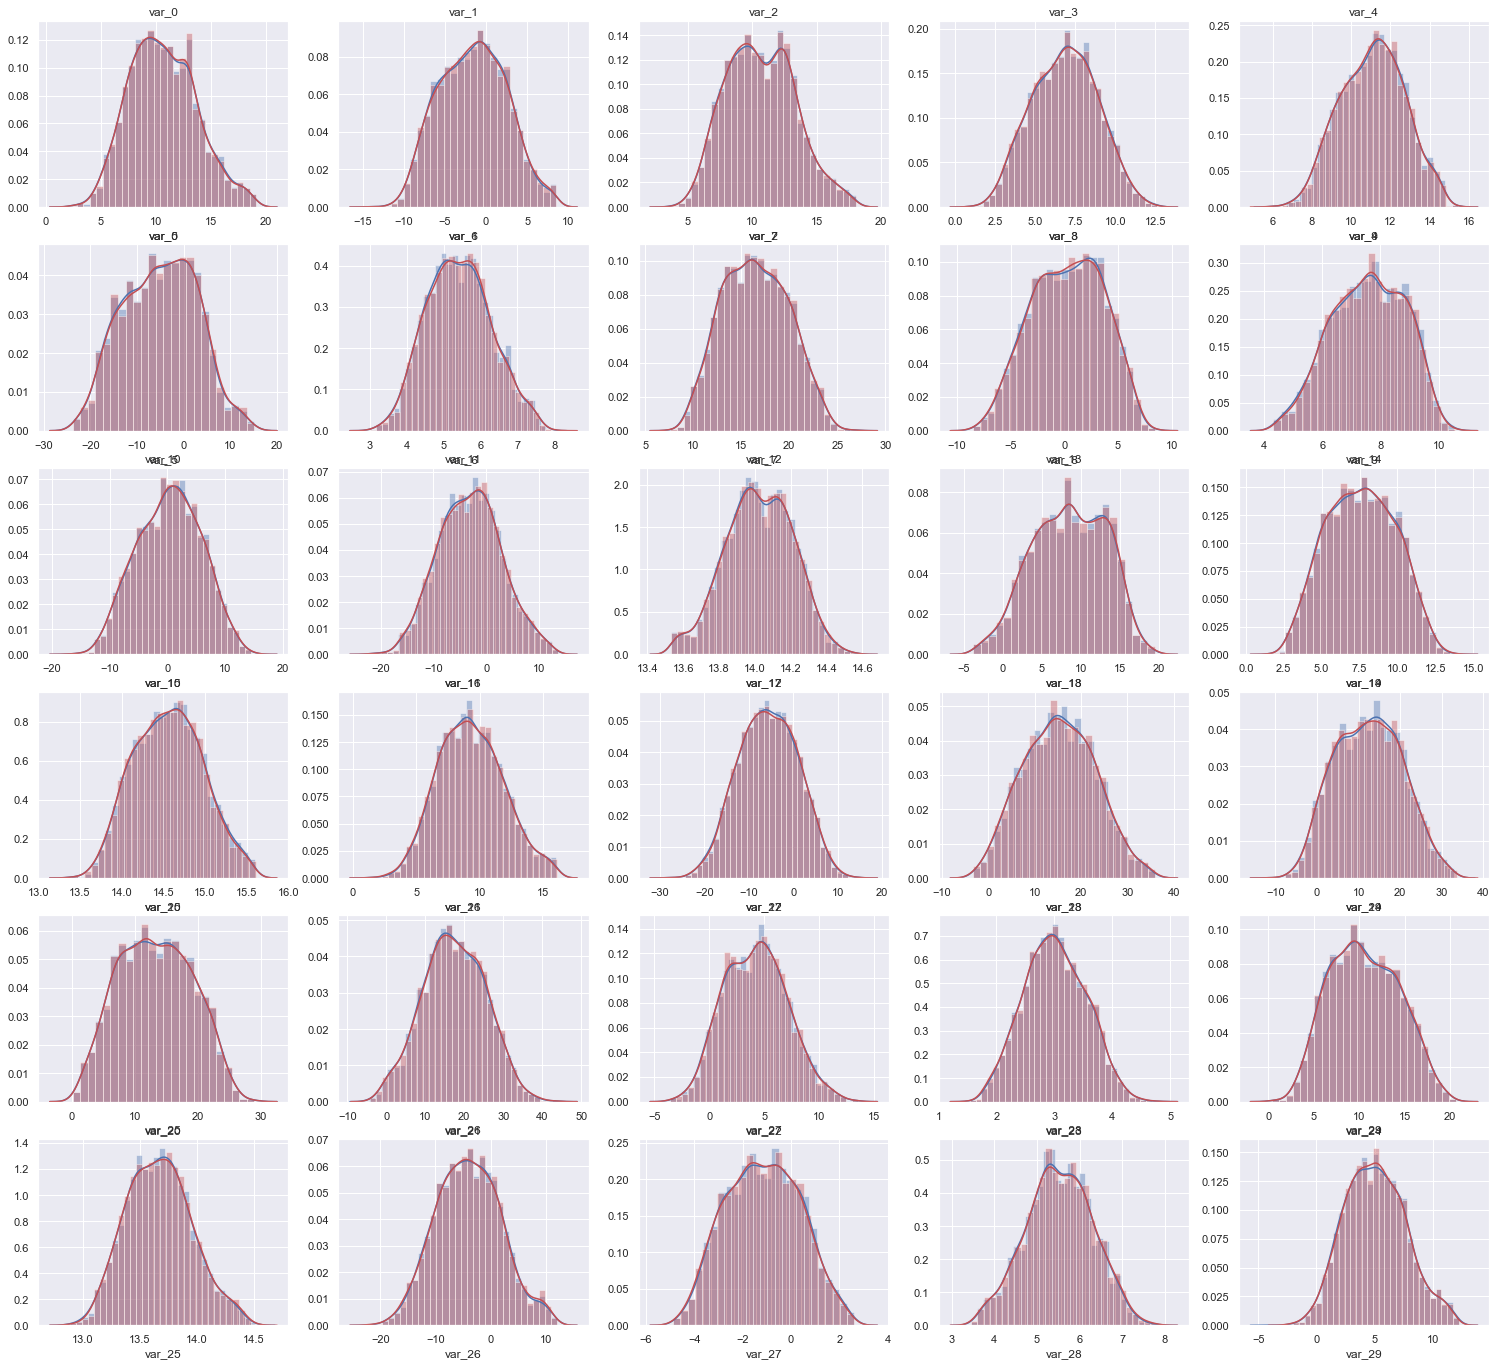

In [654]:
idx = 0
print('Distributions of first 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(col_list[30*idx:30*(idx+1)]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train[col], color='b')
    sns.distplot(train_shake[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


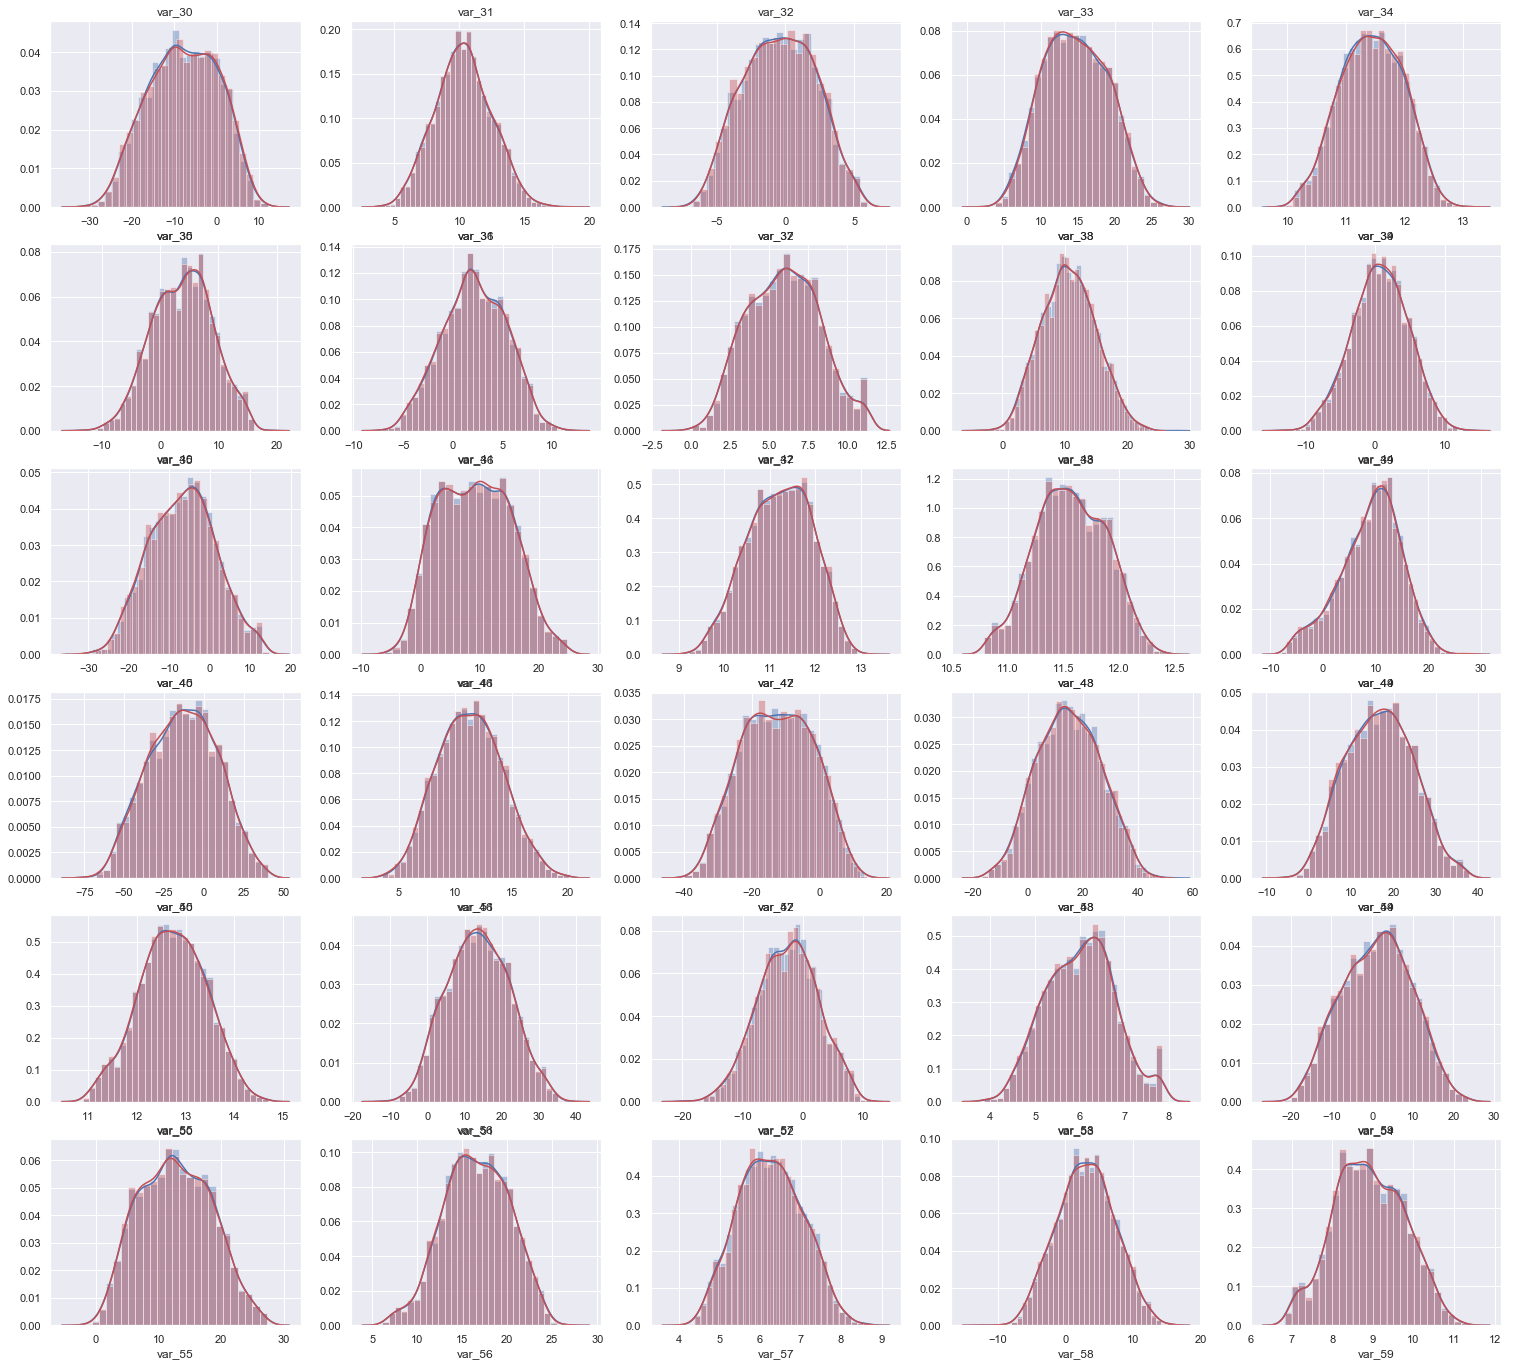

In [655]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(col_list[30*idx:30*(idx+1)]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train[col], color='b')
    sns.distplot(train_shake[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


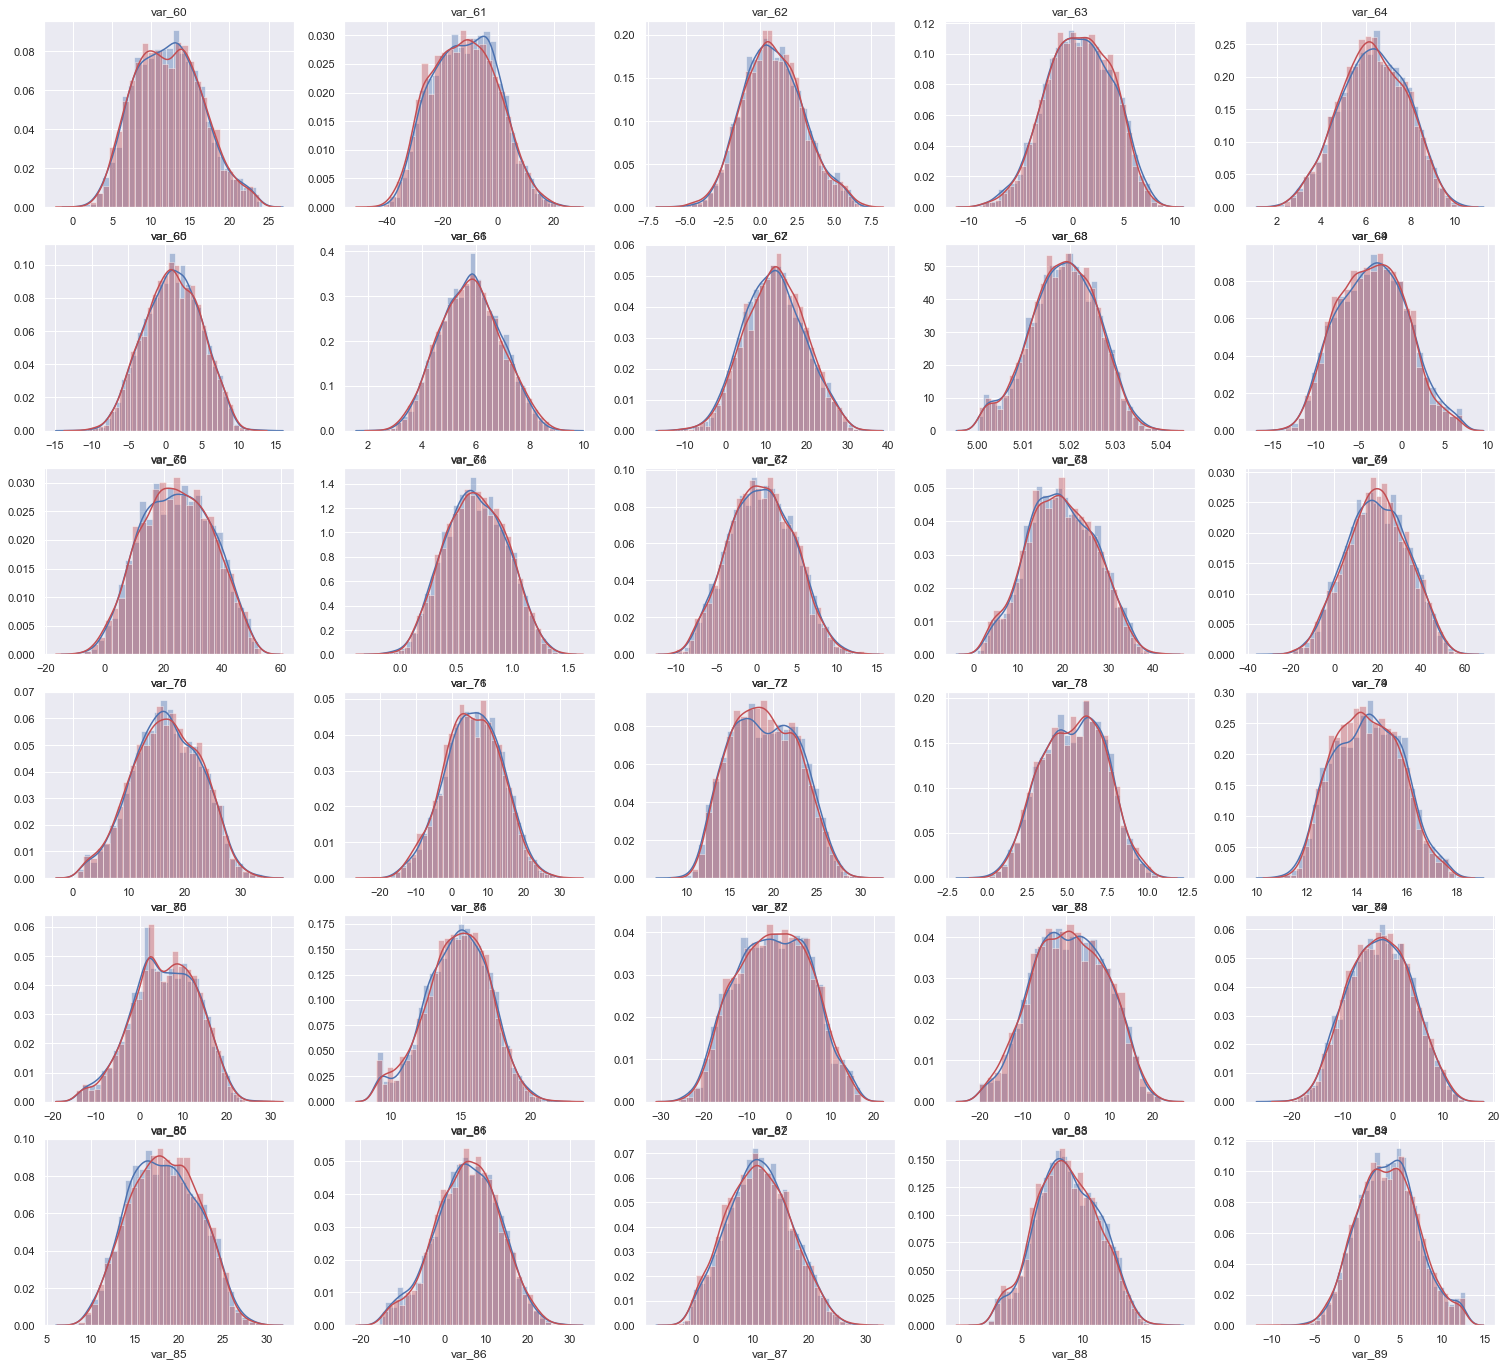

In [602]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(col_list[30*idx:30*(idx+1)]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train[col], color='b')
    sns.distplot(train_shake[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


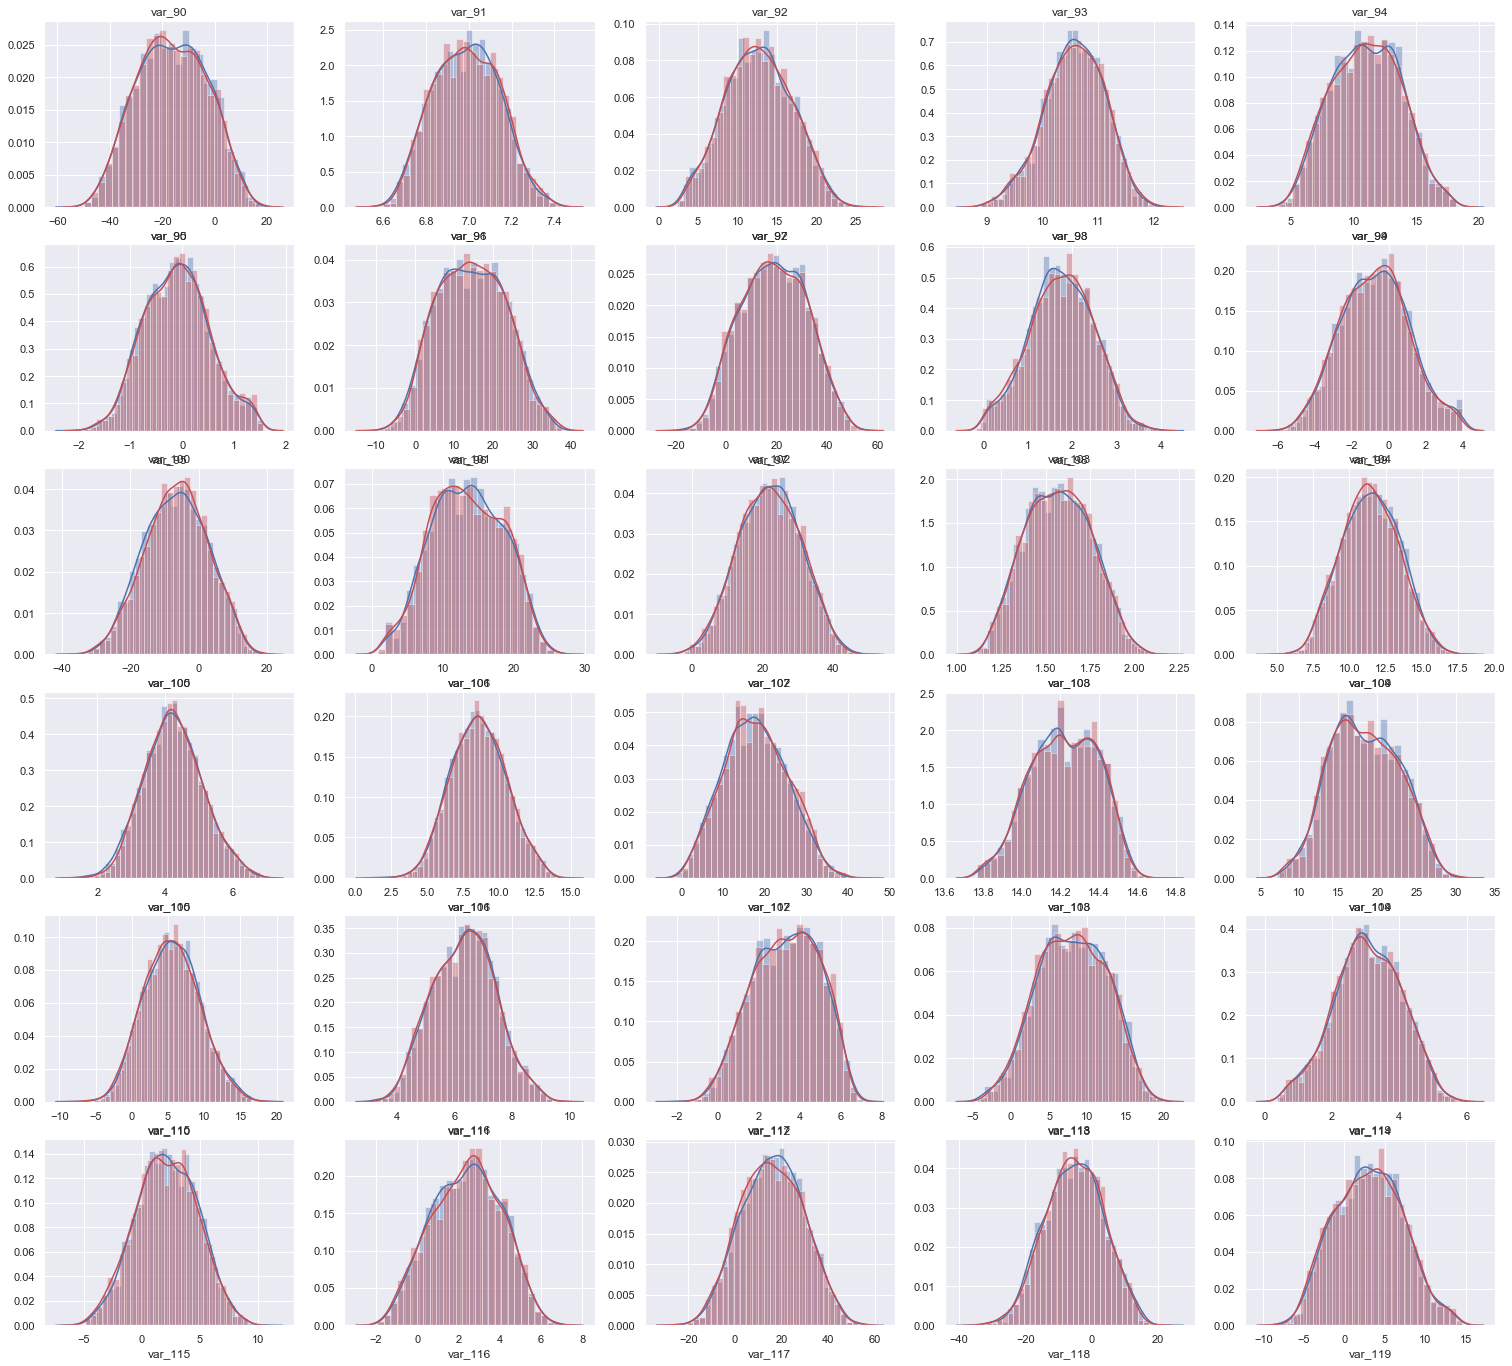

In [603]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(col_list[30*idx:30*(idx+1)]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train[col], color='b')
    sns.distplot(train_shake[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


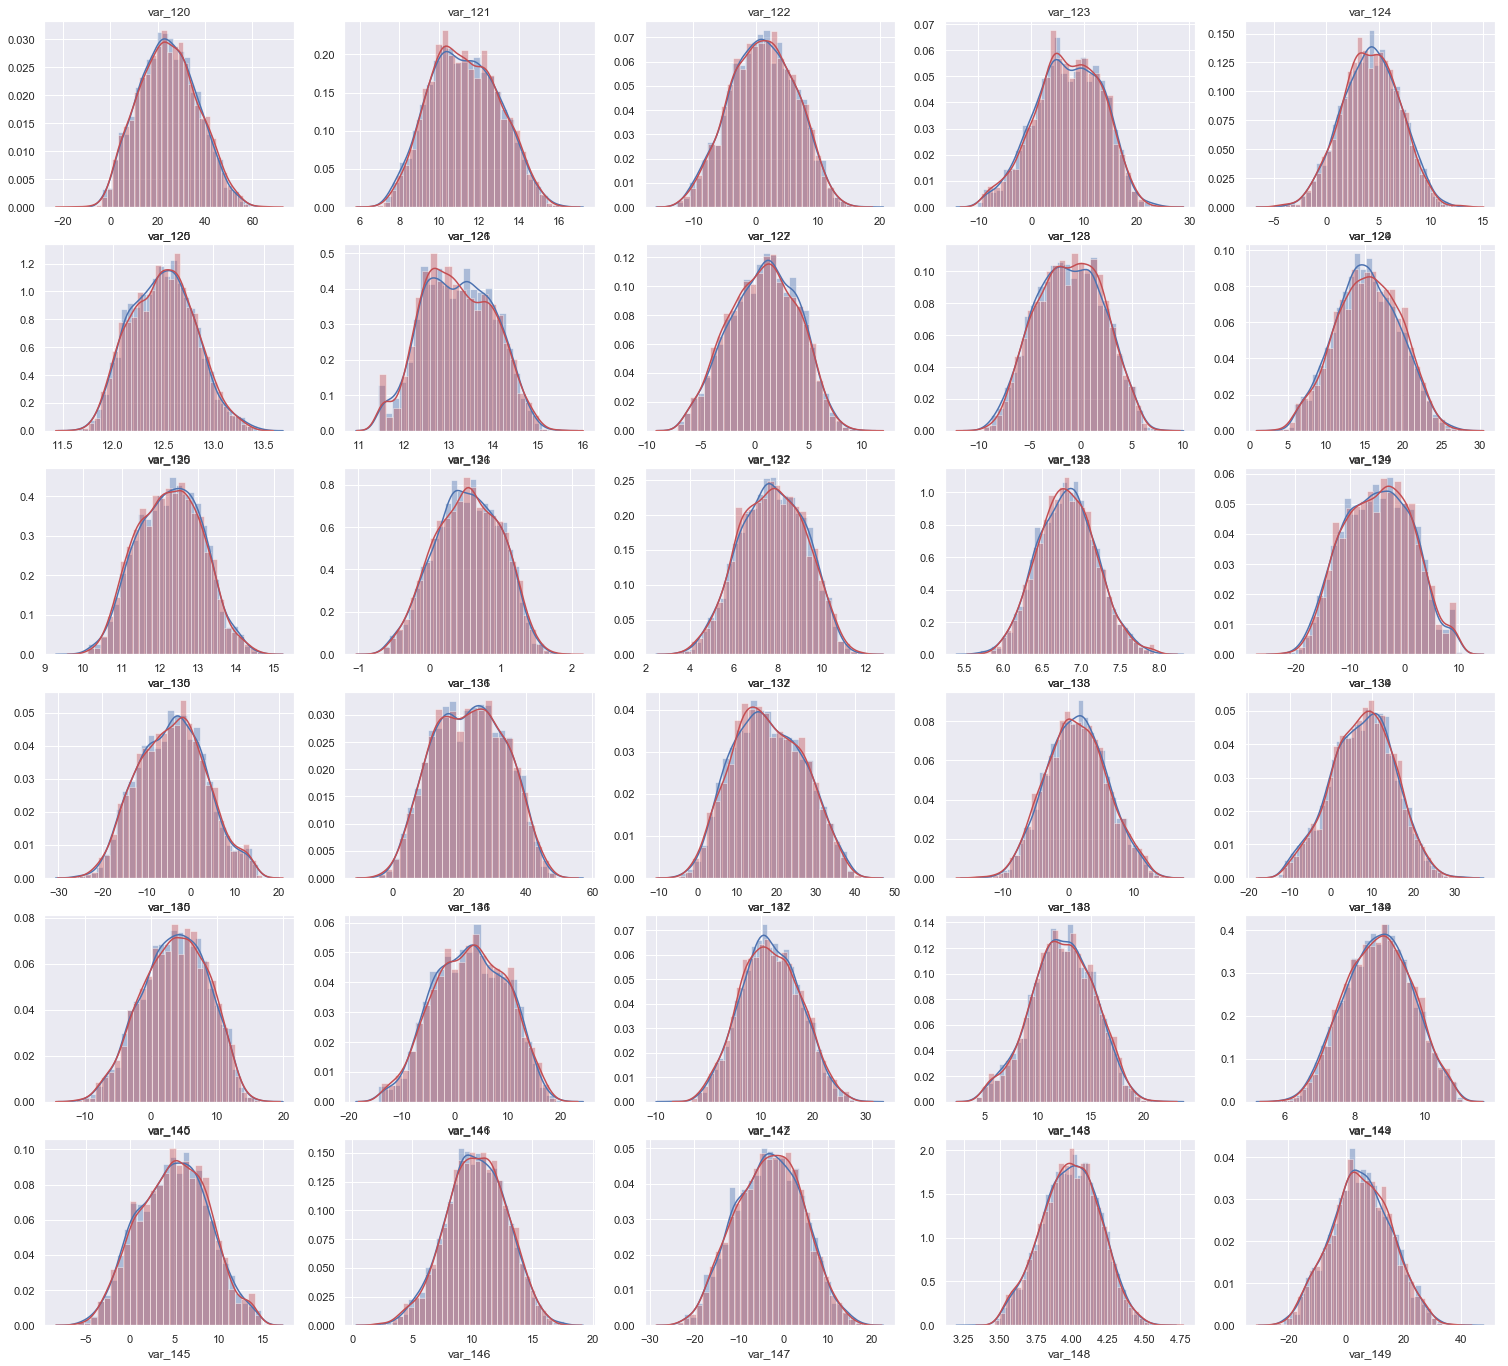

In [604]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(col_list[30*idx:30*(idx+1)]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train[col], color='b')
    sns.distplot(train_shake[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


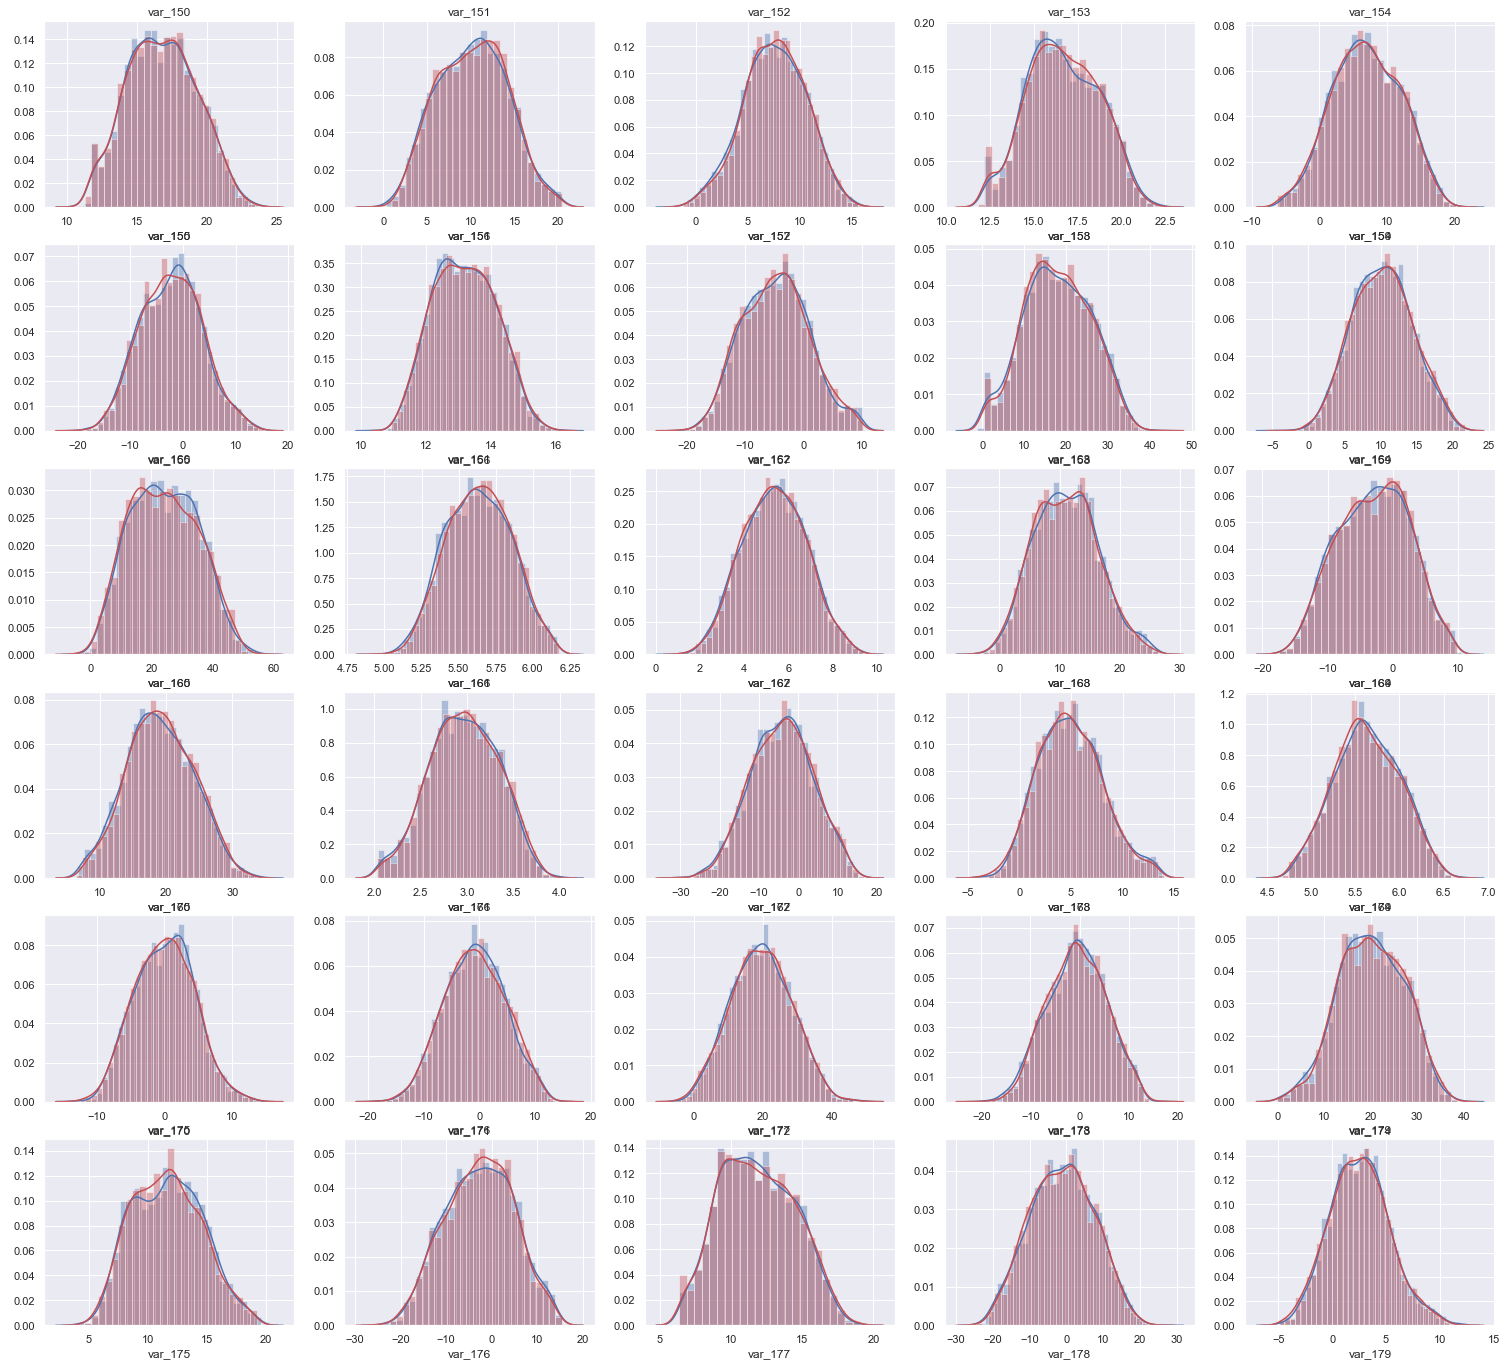

In [605]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(col_list[30*idx:30*(idx+1)]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train[col], color='b')
    sns.distplot(train_shake[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


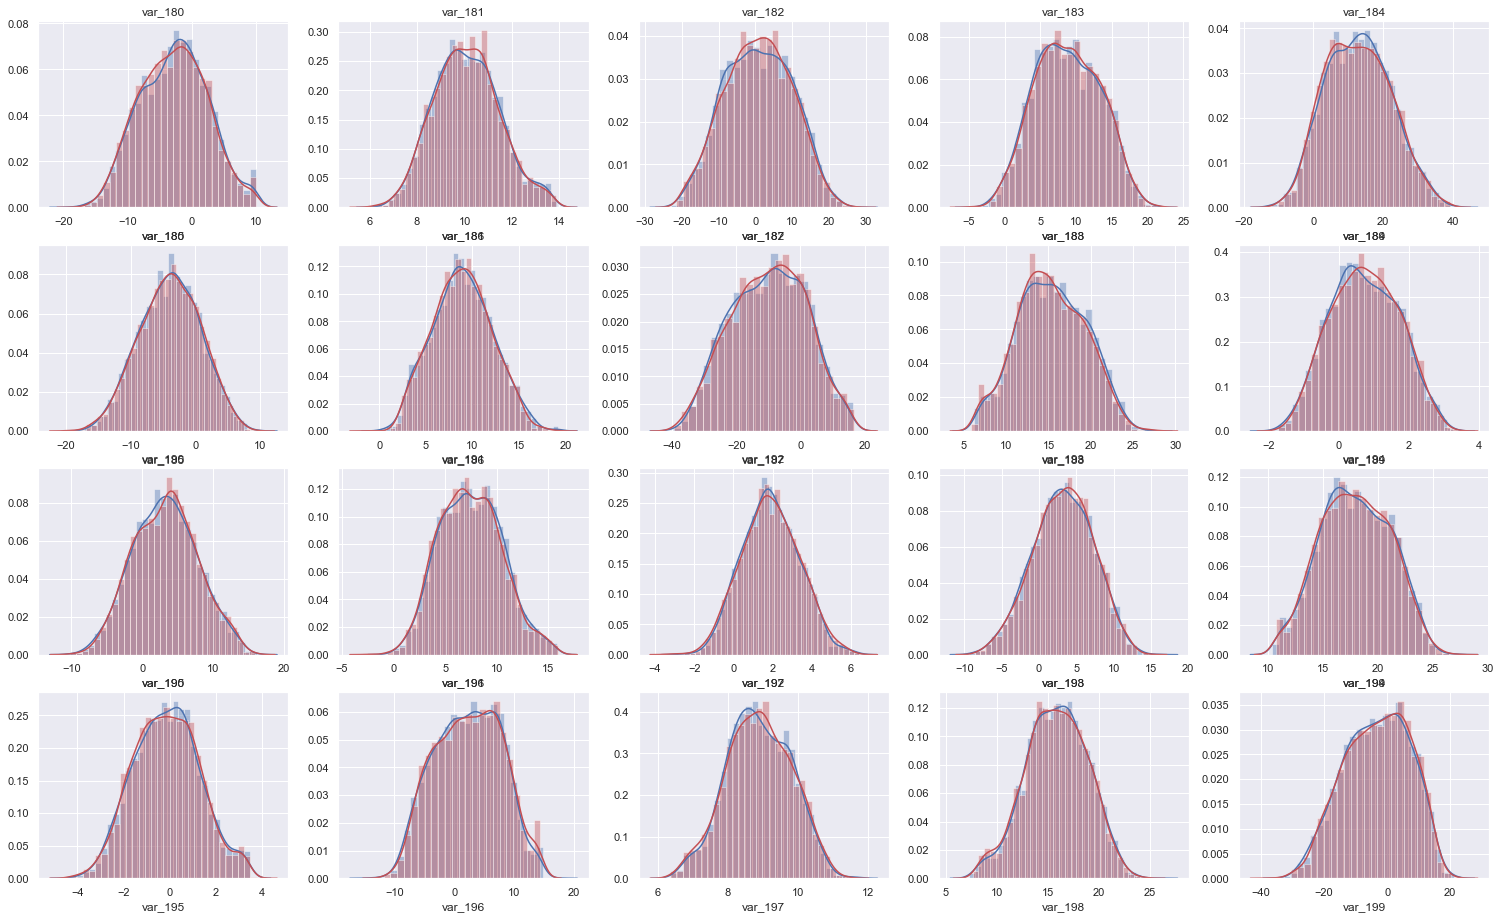

In [606]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(col_list[30*idx:30*(idx+1)]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train[col], color='b')
    sns.distplot(train_shake[col], color='r')
    plt.title(col)

idx += 1

In [607]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(col_list[30*idx:30*(idx+1)]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train[col], color='b')
    sns.distplot(train_shake[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


<Figure size 1872x1728 with 0 Axes>

* var4, var10, var12

# Model

In [528]:
target = train['target']

In [529]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [125]:
param = {
    'bagging_freq': 5,          
    'bagging_fraction': 0.38,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.04,     'learning_rate': 0.0085,
    'max_depth': -1,             'metric':'auc',                'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,            'num_threads': 8,              'tree_learner': 'serial',   'objective': 'binary',
    'reg_alpha': 0.1302650970728192, 'reg_lambda': 0.3603427518866501,'verbosity': 1
}

In [531]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

np.random.seed(42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()
val_datas = np.zeros([200000, 201])
fold_list = {}

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):
    fold_list['fold_' + str(fold_)] = val_idx
    print("fold n°{}".format(fold_))
    
    trn_data = train.iloc[trn_idx].copy()
    val_data = train.iloc[val_idx].copy()

    val_data_temp = val_data.copy()
    
    print("make validation data set")
    val_datas[val_idx] = val_data.drop(['ID_code'], axis=1)
    
    trn_data = lgb.Dataset(trn_data[train_columns], label=trn_data.target)
    val_data = lgb.Dataset(val_data[train_columns], label=val_data.target)

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(val_data_temp[train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    print("CV score: {:<8.5f}".format(roc_auc_score(val_data_temp.target, oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
make validation data set
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921561	valid_1's auc: 0.896028
[6000]	training's auc: 0.93604	valid_1's auc: 0.899441
Early stopping, best iteration is:
[6067]	training's auc: 0.936302	valid_1's auc: 0.899503
CV score: 0.89950 
CV score: 0.89950 
fold n°1
make validation data set
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921516	valid_1's auc: 0.897313
[6000]	training's auc: 0.935852	valid_1's auc: 0.899958
Early stopping, best iteration is:
[6330]	training's auc: 0.937156	valid_1's auc: 0.900005
CV score: 0.90000 
CV score: 0.90000 
fold n°2
make validation data set
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.92043	valid_1's auc: 0.902095
[6000]	training's auc: 0.934863	valid_1's auc: 0.905863
Early stopping, best iteration is:
[6644]	training's auc: 0.937438	valid_1's auc: 0.906232
CV score: 0.90623 
CV scor

## 삐꾸 찾기

In [532]:
train['pred'] = oof_lgb

In [533]:
ID_codes = train[(train.target == 1) & (train.pred <= 0.1)].ID_code.values

In [534]:
train['bbiggu'] = 0
train['fold'] = 0

In [535]:
train.loc[train.ID_code.isin(ID_codes), 'bbiggu'] = 1

In [536]:
def get_fold(data):
    if data['index'] in fold_list['fold_0']:
        return 1
    if data['index'] in fold_list['fold_1']:
        return 2
    if data['index'] in fold_list['fold_2']:
        return 3
    if data['index'] in fold_list['fold_3']:
        return 4
    if data['index'] in fold_list['fold_4']:
        return 5

In [537]:
train['fold'] = train.reset_index().apply(get_fold, axis=1)

In [538]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,pred,bbiggu,fold
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,0.014813,0,1
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,

In [539]:
train[['ID_code', 'pred', 'bbiggu', 'fold']].to_csv('./data_temp/bbiggu_1.csv', index=False)

# Mixed Row Model

## Mixed Row Data

In [316]:
train_0 = train[train.target == 0].copy()
train_1 = train[train.target == 1].copy()

In [216]:
np.random.seed(42)

In [318]:
for col in tqdm_notebook(col_list):
    temp = train_0[col].values
    np.random.shuffle(temp)
    train_0[col] = temp

In [218]:
for col in tqdm_notebook(col_list):
    temp = train_1[col].values
    np.random.shuffle(temp)
    train_1[col] = temp

In [221]:
train = train_0.append(train_1).sort_index()

In [224]:
target = train['target']

In [225]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [226]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()
fold_list = {}

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):
    fold_list['fold_' + str(fold_)] = val_idx
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.920604	valid_1's auc: 0.898184
[6000]	training's auc: 0.935027	valid_1's auc: 0.901859
Early stopping, best iteration is:
[7141]	training's auc: 0.939524	valid_1's auc: 0.902176
CV score: 0.90218 
fold n°1
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921567	valid_1's auc: 0.895421
[6000]	training's auc: 0.935865	valid_1's auc: 0.898824
Early stopping, best iteration is:
[6603]	training's auc: 0.938274	valid_1's auc: 0.89905
CV score: 0.89905 
fold n°2
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.920662	valid_1's auc: 0.898167
[6000]	training's auc: 0.935208	valid_1's auc: 0.901748
Early stopping, best iteration is:
[6507]	training's auc: 0.937263	valid_1's auc: 0.901845
CV score: 0.90184 
fold n°3
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.9216	valid_1's auc: 0.

## 각 폴드별로 Mix

In [344]:
target = train['target']

In [345]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [349]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

np.random.seed(42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()
val_datas = np.zeros([200000, 201])
fold_list = {}

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):
    fold_list['fold_' + str(fold_)] = val_idx
    print("fold n°{}".format(fold_))
    
    trn_data = train.iloc[trn_idx].copy()
    val_data = train.iloc[val_idx].copy()
    
    trn_data_0 = trn_data[trn_data.target == 0]
    trn_data_1 = trn_data[trn_data.target == 1]
    
    val_data_0 = val_data[val_data.target == 0]
    val_data_1 = val_data[val_data.target == 1]
    
    print("shuffling ...")
    print("1", end=" ")
    for col in tqdm_notebook(col_list):
        temp = trn_data_0[col].values
        np.random.shuffle(temp)
        trn_data_0[col] = temp
        
    print("2", end=" ")
    for col in tqdm_notebook(col_list):
        temp = trn_data_1[col].values
        np.random.shuffle(temp)
        trn_data_1[col] = temp
        
    print("3", end=" ")
    for col in tqdm_notebook(col_list):
        temp = val_data_0[col].values
        np.random.shuffle(temp)
        val_data_0[col] = temp
    
    print("4", end=" ")
    for col in tqdm_notebook(col_list):
        temp = val_data_1[col].values
        np.random.shuffle(temp)
        val_data_1[col] = temp
        
    trn_data = trn_data_0.append(trn_data_1).sort_index()
    val_data = val_data_0.append(val_data_1).sort_index()
    val_data_temp = val_data.copy()
    
    print("make validation data set")
    val_datas[val_idx] = val_data.drop(['ID_code'], axis=1)
    
    trn_data = lgb.Dataset(trn_data[train_columns], label=trn_data.target)
    val_data = lgb.Dataset(val_data[train_columns], label=val_data.target)

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(val_data_temp[train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    print("CV score: {:<8.5f}".format(roc_auc_score(val_data_temp.target, oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
shuffling ...
1 

2 

3 

4 

make validation data set
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.922263	valid_1's auc: 0.898177
[6000]	training's auc: 0.936229	valid_1's auc: 0.901781
Early stopping, best iteration is:
[7725]	training's auc: 0.942781	valid_1's auc: 0.902319
CV score: 0.90232 
CV score: 0.90232 
fold n°1
shuffling ...
1 

2 

3 

4 

make validation data set
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921139	valid_1's auc: 0.896156
[6000]	training's auc: 0.935727	valid_1's auc: 0.899288
Early stopping, best iteration is:
[5914]	training's auc: 0.935387	valid_1's auc: 0.899363
CV score: 0.89936 
CV score: 0.89936 
fold n°2
shuffling ...
1 

2 

3 

4 

make validation data set
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.920533	valid_1's auc: 0.897245
[6000]	training's auc: 0.934718	valid_1's auc: 0.901096
Early stopping, best iteration is:
[6151]	training's auc: 0.935339	valid_1's auc: 0.901209
CV score: 0.90121 
CV score: 0.90121 
fold n°3
shuffling ...
1 

2 

3 

4 

make validation data set
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921628	valid_1's auc: 0.897209
[6000]	training's auc: 0.936171	valid_1's auc: 0.901266
Early stopping, best iteration is:
[6647]	training's auc: 0.938778	valid_1's auc: 0.901663
CV score: 0.90166 
CV score: 0.90166 
fold n°4
shuffling ...
1 

2 

3 

4 

make validation data set
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921718	valid_1's auc: 0.895182
[6000]	training's auc: 0.935807	valid_1's auc: 0.898945
Early stopping, best iteration is:
[6665]	training's auc: 0.938424	valid_1's auc: 0.899144
CV score: 0.89914 
CV score: 0.89914 
CV score: 0.90071 


In [357]:
train.columns[1:]

Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [362]:
train_shake = pd.DataFrame(val_datas, columns=train.columns[1:])
train_shake['ID_code'] = train.ID_code

## 삐꾸 찾기

In [365]:
train_shake['pred'] = oof_lgb

In [366]:
ID_codes = train_shake[(train_shake.target == 1) & (train_shake.pred <= 0.1)].ID_code.values

In [367]:
train_shake['bbiggu'] = 0
train_shake['fold'] = 0

In [368]:
train_shake.loc[train_shake.ID_code.isin(ID_codes), 'bbiggu'] = 1

In [369]:
def get_fold(data):
    if data['index'] in fold_list['fold_0']:
        return 1
    if data['index'] in fold_list['fold_1']:
        return 2
    if data['index'] in fold_list['fold_2']:
        return 3
    if data['index'] in fold_list['fold_3']:
        return 4
    if data['index'] in fold_list['fold_4']:
        return 5

In [370]:
train_shake['fold'] = train_shake.reset_index().apply(get_fold, axis=1)

In [372]:
train_shake.drop(['pred', 'bbiggu', 'fold'], axis=1).to_csv('./data_temp/train_shake.csv', index=False)

In [374]:
train_shake[['ID_code', 'pred', 'bbiggu', 'fold']].to_csv('./data_temp/bbiggu_shake_1.csv', index=False)

# 삐꾸 데이터 빼고 학습

In [618]:
id_code = bbiggu_1[bbiggu_1.bbiggu_1 == 0].ID_code

In [623]:
train = train[train.ID_code.isin(id_code)]

In [624]:
target = train['target']

In [625]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [626]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

np.random.seed(42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()
val_datas = np.zeros([200000, 201])
fold_list = {}

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):
    fold_list['fold_' + str(fold_)] = val_idx
    print("fold n°{}".format(fold_))
    
    trn_data = train.iloc[trn_idx].copy()
    val_data = train.iloc[val_idx].copy()

    val_data_temp = val_data.copy()
    
    print("make validation data set")
    val_datas[val_idx] = val_data.drop(['ID_code'], axis=1)
    
    trn_data = lgb.Dataset(trn_data[train_columns], label=trn_data.target)
    val_data = lgb.Dataset(val_data[train_columns], label=val_data.target)

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(val_data_temp[train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    print("CV score: {:<8.5f}".format(roc_auc_score(val_data_temp.target, oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
make validation data set
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.970965	valid_1's auc: 0.953654
[6000]	training's auc: 0.979519	valid_1's auc: 0.957067
Early stopping, best iteration is:
[6959]	training's auc: 0.98142	valid_1's auc: 0.957338
CV score: 0.95734 
CV score: 0.95734 
fold n°1
make validation data set
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: 

In [664]:
roc_auc_score(train.target, bbiggu_1.pred_1)

0.9001888365158383